# Notebook 05: Regresión Lineal con Evaluación Completa

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, abs as spark_abs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuración de Spark
spark = SparkSession.builder \
    .appName("SECOP_RegresionLineal") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

# Cargar datos
df = spark.read.parquet("/opt/spark-data/processed/secop_ml_ready.parquet")

print(f"Registros cargados: {df.count():,}")
df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/15 02:47:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Registros cargados: 441,948
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd

spark = (SparkSession.builder
    .appName("SECOP_RegresionLineal")
    .master("local[*]")
    .getOrCreate())

26/02/15 02:47:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
# Cargar dataset con features PCA y label
df = spark.read.parquet("/opt/spark-data/processed/secop_ml_ready.parquet")
df = df.withColumnRenamed("features_pca", "features")
df.printSchema()
print(f"Registros: {df.count():,}")

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

Registros: 441,948


### Reto 1: Estrategia de train/test split

### Reto 2: Configurar modelo de LinearRegression

In [ ]:
# %% RETO 1: Train/Test Split
# Usamos 80/20
train, test = df.randomSplit([0.8, 0.2], seed=42)
train.cache()

# %% RETO 2: Configurar LinearRegression
lr = LinearRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.0,
    elasticNetParam=0.0,
    solver="auto"
)

print("Entrenando modelo de Regresión Lineal...")
lr_model = lr.fit(train)


Entrenando modelo de Regresión Lineal...


26/02/15 02:47:56 WARN Instrumentation: [ba1ad7b7] regParam is zero, which might cause numerical instability and overfitting.
26/02/15 02:47:57 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
26/02/15 02:47:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/02/15 02:47:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
26/02/15 02:47:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
26/02/15 02:47:57 WARN Instrumentation: [ba1ad7b7] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


### Reto 3: Interpretar R²

### Reto 4: Analizar calidad de predicciones y errores

### Reto 5: Comparar train vs test (detección de overfitting)

In [5]:
# %% RETO 3, 4 y 5: Evaluación y Overfitting
train_pred = lr_model.transform(train)
test_pred = lr_model.transform(test)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Cálculo de métricas
metrics = {}
for metric in ["rmse", "r2", "mae"]:
    metrics[f"train_{metric}"] = evaluator.setMetricName(metric).evaluate(train_pred)
    metrics[f"test_{metric}"] = evaluator.setMetricName(metric).evaluate(test_pred)

print(f"\n--- RESULTADOS DEL MODELO ---")
print(f"Train R²: {metrics['train_r2']:.4f} | Test R²: {metrics['test_r2']:.4f}")
print(f"Train RMSE: {metrics['train_rmse']:,.2f} | Test RMSE: {metrics['test_rmse']:,.2f}")
print(f"MAE (Error promedio en pesos): ${metrics['test_mae']:,.2f}")


--- RESULTADOS DEL MODELO ---
Train R²: 0.0091 | Test R²: 0.0039
Train RMSE: 8,766,017,011.61 | Test RMSE: 8,000,886,324.41
MAE (Error promedio en pesos): $406,915,878.55


Interpretación: El modelo tiene un desempeño muy pobre:
Train R² = 0.0091: El modelo solo explica el 0.91% de la variabilidad en el valor de los contratos en los datos de entrenamiento
Test R² = 0.0039: En datos de prueba, solo explica el 0.39% de la variabilidad

### Reto 6: Analizar coeficientes del modelo

In [6]:
# %% RETO 6: Análisis de Coeficientes e Intercepto
coeffs = lr_model.coefficients.toArray()
print(f"\nIntercepto (Base): ${lr_model.intercept:,.2f}")
print(f"Número de coeficientes: {len(coeffs)}")


Intercepto (Base): $558,398,616.00
Número de coeficientes: 64


### Bonus 1: Distribución de residuos

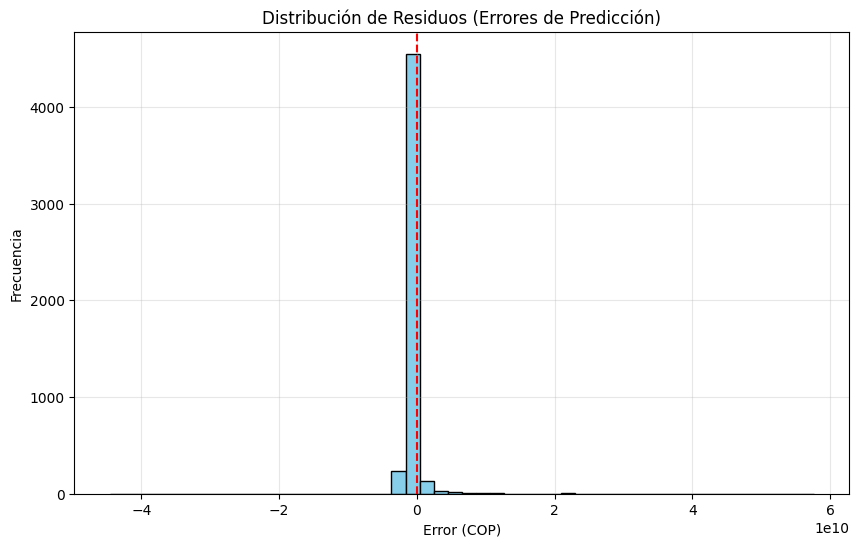

In [7]:
# %% BONUS 1: Análisis de Residuos
# Un residuo es: Valor Real - Predicción
test_res = test_pred.withColumn("residual", col("label") - col("prediction"))
pdf_res = test_res.select("residual").limit(5000).toPandas()



plt.figure(figsize=(10, 6))
plt.hist(pdf_res['residual'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribución de Residuos (Errores de Predicción)')
plt.xlabel('Error (COP)')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)
plt.savefig('/opt/spark-data/processed/residuos_dist_lr.png')
plt.show()

### Bonus 2: Feature importance aproximado (magnitud de coeficientes)

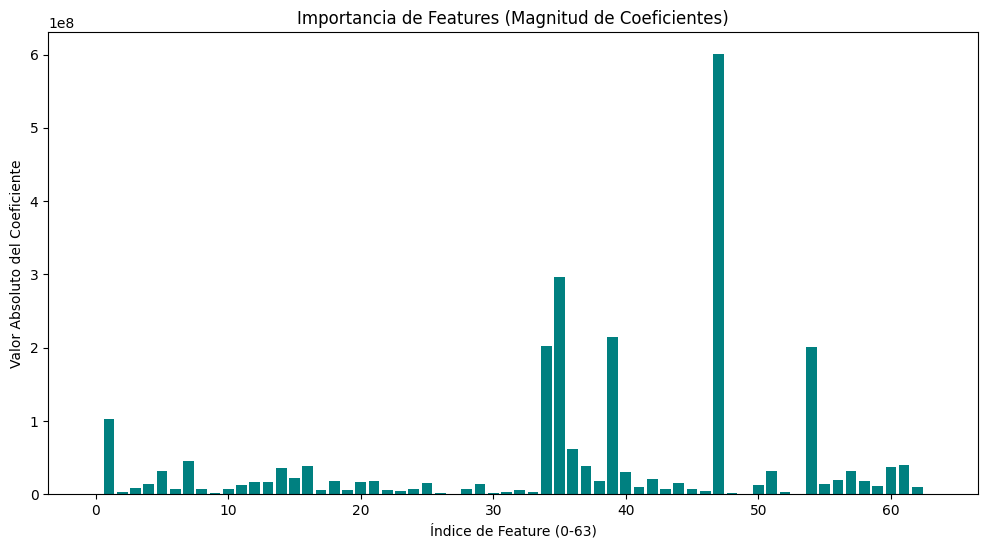

Proceso completado.


In [8]:
# %% BONUS 2: Feature Importance (Magnitud de coeficientes)
# Al no haber PCA, estas barras representan el peso de tus variables originales escaladas
plt.figure(figsize=(12, 6))
plt.bar(range(len(coeffs)), [abs(c) for c in coeffs], color='teal')
plt.title('Importancia de Features (Magnitud de Coeficientes)')
plt.xlabel('Índice de Feature (0-63)')
plt.ylabel('Valor Absoluto del Coeficiente')
plt.savefig('/opt/spark-data/processed/feature_importance_lr.png')
plt.show()

# Guardar predicciones para análisis posterior
test_pred.select("label", "prediction").write.mode("overwrite").parquet("/opt/spark-data/processed/predicciones_lr.parquet")

print("Proceso completado.")


In [9]:
spark.stop()